In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming filtered_data is the DataFrame from the previuos notebook
%store -r filtered_data
# Identify categorical and numerical columns
categorical_columns = filtered_data.select_dtypes(include=['object']).columns
numerical_columns = filtered_data.select_dtypes(include=['int', 'float']).columns

# Manual one-hot encoding using pandas get_dummies
encoded_categorical_df = pd.get_dummies(filtered_data[categorical_columns])

# Manual MinMax scaling
scaled_numerical_df = (filtered_data[numerical_columns] - filtered_data[numerical_columns].min()) / (filtered_data[numerical_columns].max() - filtered_data[numerical_columns].min())

# Concatenation of encoded categorical and scaled numerical DataFrames
processed_data = pd.concat([encoded_categorical_df, filtered_data[numerical_columns]], axis=1)

# ignoring min max sxcaling on decision trees


In [73]:
print("processed_data: \n",processed_data.describe())
      
      
X = processed_data.drop(['risk','Sex_M','Smoking_yes','Heart rate data used_0.0'], axis=1)
y = processed_data['risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

processed_data: 
               Age         BMI  MET (activity level)        risk
count  209.000000  209.000000            209.000000  209.000000
mean    39.820818   26.493015             13.177336    0.582553
std      9.434708    5.090887             10.783680    0.367613
min     22.999316   17.226562              0.145333    0.001500
25%     31.841422   23.146952              5.221824    0.320000
50%     39.491456   25.468471             10.628157    0.488300
75%     46.974710   28.731747             19.654733    0.772300
max     60.645249   42.201019             58.289505    2.439100


In [81]:

# Create an instance of the Decision Tree regressor
model = DecisionTreeRegressor(min_samples_split=5,max_depth=3)  # test max_depath=7 for the highest fit
#print(filtered_data[numerical_columns])
# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the outcome variable for the test data
y_pred = model.predict(X_test)

In [83]:
# Assuming y_test and y_pred are the true outcome values and the predicted values, respectively
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('R-squared:', model.score(X_test, y_test))
print("RMSE:", rmse)

R-squared: 0.6648992678044949
RMSE: 0.243613359508252


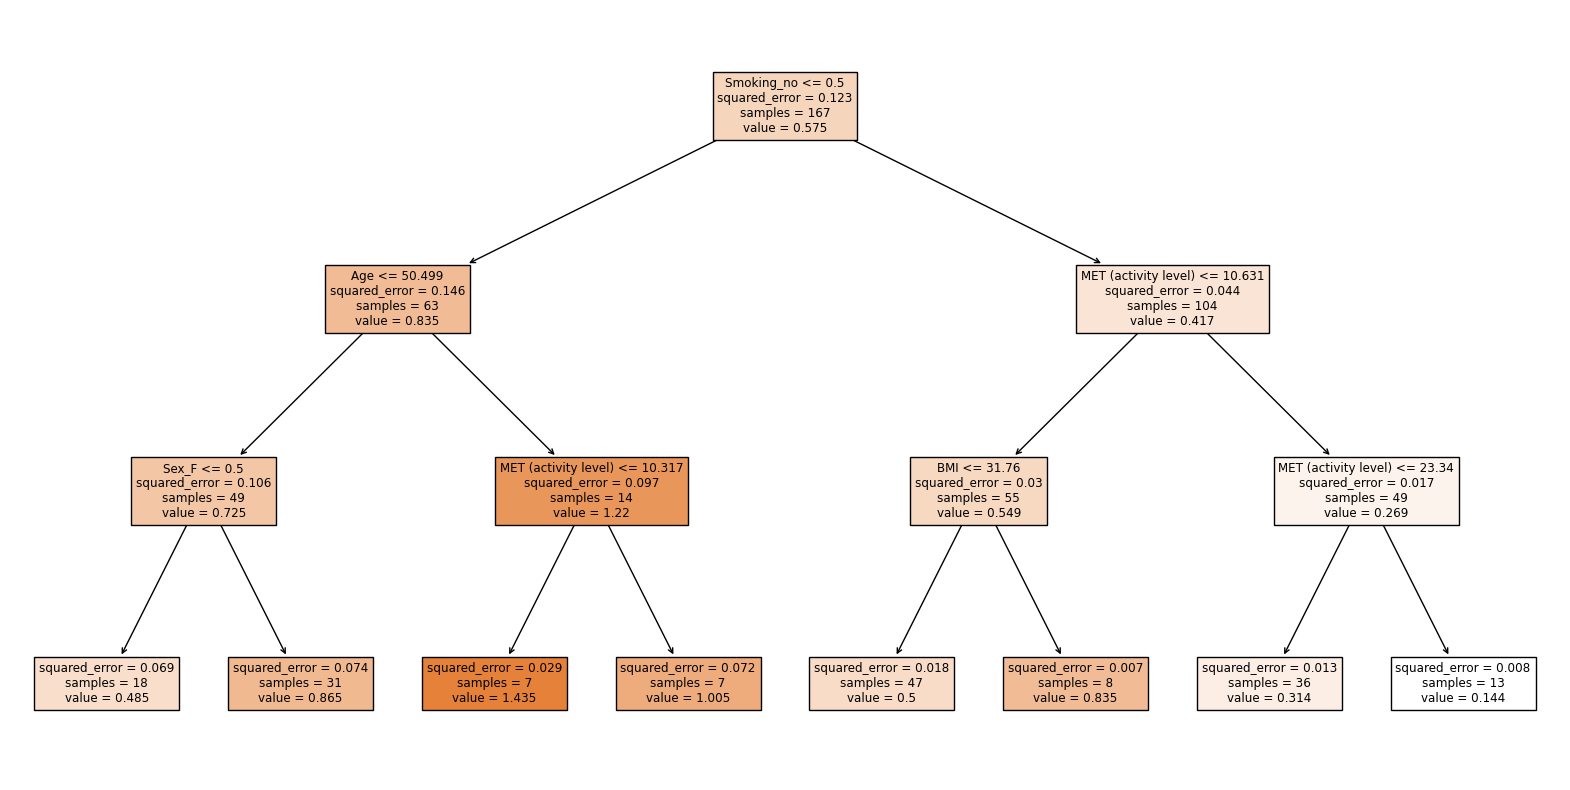

In [84]:
# Convert the Index object to a list
feature_names = list(X.columns)

# Assuming model is the trained Decision Tree regressor
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()


#
Tuning the tree that was used above

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'DT': DecisionTreeRegressor() ,
}

hyperparams = {
   'DT': {'max_depth': [3, 5,7], 'min_samples_split': [ 5, 10]}
}
results = {}
model_scores={}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, hyperparams[model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(f"Scores for {model_name}:")
    results = grid_search.cv_results_
    for mean_score, params in zip(results['mean_test_score'], results['params']):
        r2_scores = 1 - (mean_score * -1) / np.var(y_train)  # Calculate R2 score
        print(f"Hyperparameters: {params} R2 score: {r2_scores}")
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_scores[model_name] = {'MSE': mse, 'R2': r2 , 'params' : best_params}
    

# Print the MSE and R2 for each model
for model, scores in model_scores.items():
    print(f"Model: {model} Params: {scores['params']}, MSE: {scores['MSE']}, R2: {scores['R2']}")
DT=best_model

Scores for DT:
Hyperparameters: {'max_depth': 3, 'min_samples_split': 5} R2 score: 0.43059639793182214
Hyperparameters: {'max_depth': 3, 'min_samples_split': 10} R2 score: 0.43704098763848365
Hyperparameters: {'max_depth': 5, 'min_samples_split': 5} R2 score: 0.500425385521639
Hyperparameters: {'max_depth': 5, 'min_samples_split': 10} R2 score: 0.48452440377020756
Hyperparameters: {'max_depth': 7, 'min_samples_split': 5} R2 score: 0.5234027220325248
Hyperparameters: {'max_depth': 7, 'min_samples_split': 10} R2 score: 0.5043157678780592
Model: DT Params: {'max_depth': 7, 'min_samples_split': 5}, MSE: 0.05317841876660052, R2: 0.6997323156875237


# 
 # seems to have poor cross validation fit in the grid search but fit is higher in the test set
#